## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from memory_profiler import memory_usage
import wget
import time
import matplotlib.pyplot as plt
from pandas.testing import assert_frame_equal

## Load dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
output_filename = "adult.data"

# Download the dataset
try:
    print("Downloading dataset...")
    wget.download(url, output_filename)
    print(f"\nDataset downloaded successfully as '{output_filename}'")
except Exception as e:
    print(f"An error occurred: {e}")

-1 / unknown
Dataset downloaded successfully as 'adult.data'


In [3]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

df = pd.read_csv('adult.data', names=columns, skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Util functions

In [4]:
def measure_time(func):
    start_time = time.time()  # Record start time
    func()  # Execute the function
    end_time = time.time()  # Record end time
    exec_time = end_time - start_time  # Calculate the execution time
    return exec_time


def measure_memory(func):
    mem_usage = memory_usage((func,), interval=0.1)  # Record memory usage during function execution
    return mem_usage


# Method to plot the results
def plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2):
    plt.figure(figsize=(12, 6))

    # Execution time
    plt.subplot(1, 2, 1)
    plt.bar(["Good Example (f1)", "Bad Example (f2)"], [time_f1, time_f2], color=["green", "red"])
    plt.title("Execution Time Comparison")
    plt.ylabel("Time (seconds)")

    # Memory usage
    plt.subplot(1, 2, 2)
    plt.plot(mem_f1, label="Good Example (f1)", color="green")
    plt.plot(mem_f2, label="Bad Example (f2)", color="red")
    plt.title("Memory Usage Comparison")
    plt.ylabel("Memory (MB)")
    plt.xlabel("Time (interval)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# The magic of apply()

## Don't do this

In [5]:
def reformat_names_wrong():
    for index, row in df.iterrows():
        if row['native_country'] == "United-States":
            df.loc[index, "native_country"] = "USA"

## Do this instead

In [6]:
def reformat_names_good():
    df['native_country'] = df['native_country'].apply(lambda country: 'USA' if country == 'United-States' else country)

## Time - memory comparison

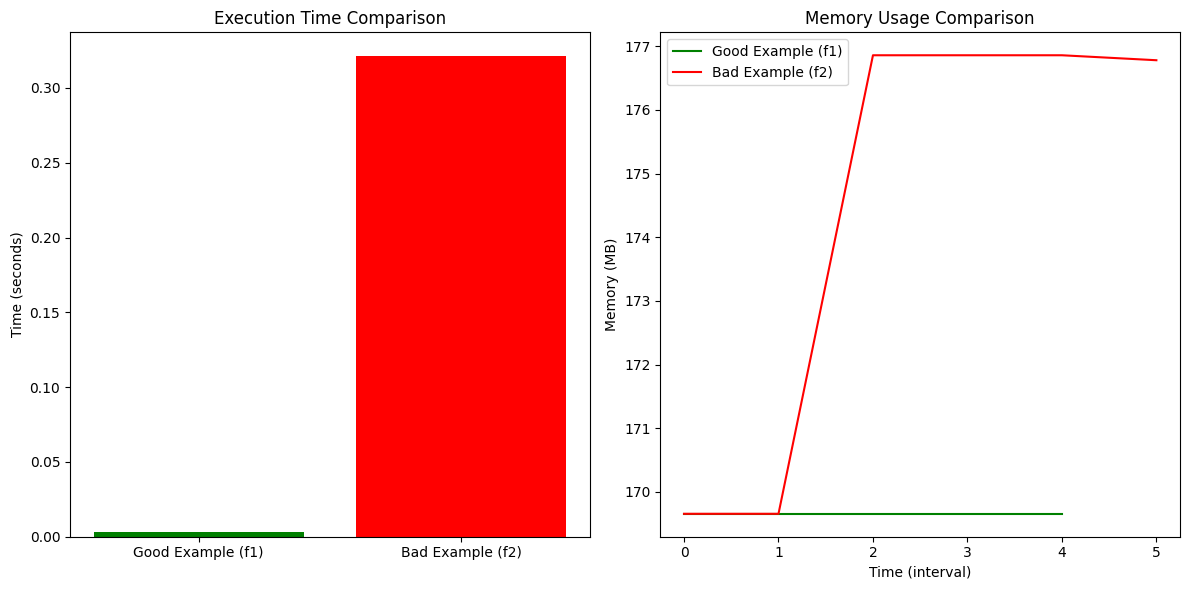

In [7]:
time_f1 = measure_time(reformat_names_good)
time_f2 = measure_time(reformat_names_wrong)

mem_f1 = measure_memory(reformat_names_good)
mem_f2 = measure_memory(reformat_names_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)

# to_datetime()

In [8]:
n = len(df)

start = pd.to_datetime('2023-01-01')
end = pd.to_datetime('2023-12-31')
random_timestamps = start + (end - start) * np.random.rand(n)
df["date_column"] = pd.Series(random_timestamps)
df["date_column"]

0       2023-05-21 18:17:21.839157088
1       2023-07-16 19:48:51.533447472
2       2023-11-10 14:47:54.975946544
3       2023-05-15 04:20:21.411326378
4       2023-01-20 21:35:27.326603641
                     ...             
32556   2023-01-25 10:21:37.682527396
32557   2023-08-28 02:55:26.267685004
32558   2023-01-26 03:23:13.210160427
32559   2023-03-20 16:37:37.424132686
32560   2023-12-13 07:07:06.482478884
Name: date_column, Length: 32561, dtype: datetime64[ns]

## Don't do this

In [9]:
def compute_date_diff_wrong():
    # Ensure date_column is treated as a string and clean up inconsistent formats
    df["date_column"] = df["date_column"].astype(str)

    # Define the comparison date as a string
    comparison_date = "2020-03-01"

    # Filter the DataFrame based on date comparison
    filtered_df = df[df["date_column"] > comparison_date]

    # Calculating the difference between two dates using a for loop
    def calculate_date_diff(date1, date2):
        # Ensure that only the date part is used (ignoring time)
        date1 = date1.split(" ")[0]  # Get the date part before the space
        date2 = date2.split(" ")[0]  # Get the date part before the space

        # Split the date part into year, month, and day
        year1, month1, day1 = map(int, date1.split("-"))
        year2, month2, day2 = map(int, date2.split("-"))

        # Naive approach: Convert the dates to "days since epoch" (ignoring finer details)
        days1 = year1 * 365 + month1 * 30 + day1
        days2 = year2 * 365 + month2 * 30 + day2

        return days1 - days2  
    # Inefficient approach: Use a for loop to calculate date differences (for demonstration)
    date_diffs = []
    for i in range(len(filtered_df)):  # Using filtered_df for consistent data
        date_diffs.append(calculate_date_diff(filtered_df.loc[i, "date_column"], comparison_date))

    # Assign the calculated date differences back to the DataFrame
    filtered_df["date_diff"] = date_diffs

    return filtered_df

## Do this instead

In [10]:
def compute_date_diff_good():
    df["date_column"] = pd.to_datetime(df["date_column"])

    comparison_date = pd.to_datetime("2020-03-01")

    # Filtering rows based on a date
    start_time = time.time()

    filtered_df = df[df["date_column"] > comparison_date]

    # Calculating the difference between two dates
    df["date_diff"] = (df["date_column"] - comparison_date).dt.days

## Time - memory comparison

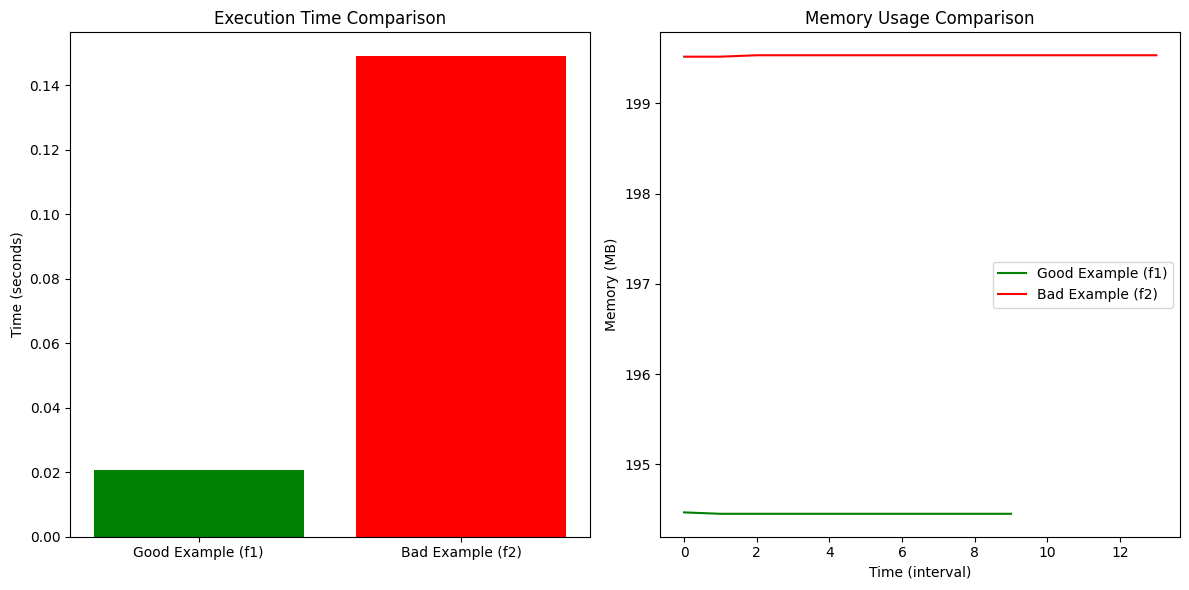

In [11]:
time_f1 = measure_time(compute_date_diff_good)
time_f2 = measure_time(compute_date_diff_wrong)

mem_f1 = measure_memory(compute_date_diff_good)
mem_f2 = measure_memory(compute_date_diff_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)

# Applymap

## Don't do this

In [15]:
def convert_to_lower_wrong():
    for col in df.columns:
        if df[col].dtype == "object":  # Check if column is string-based
            for i in range(len(df[col])):
                df.at[i, col] = df[col][i].lower()  # Inefficient and error-prone

## Do this instead

In [16]:
def convert_to_lower_good(df):
    # Applymap for element-wise transformation (works only on string cells)
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

## Time - memory comparison

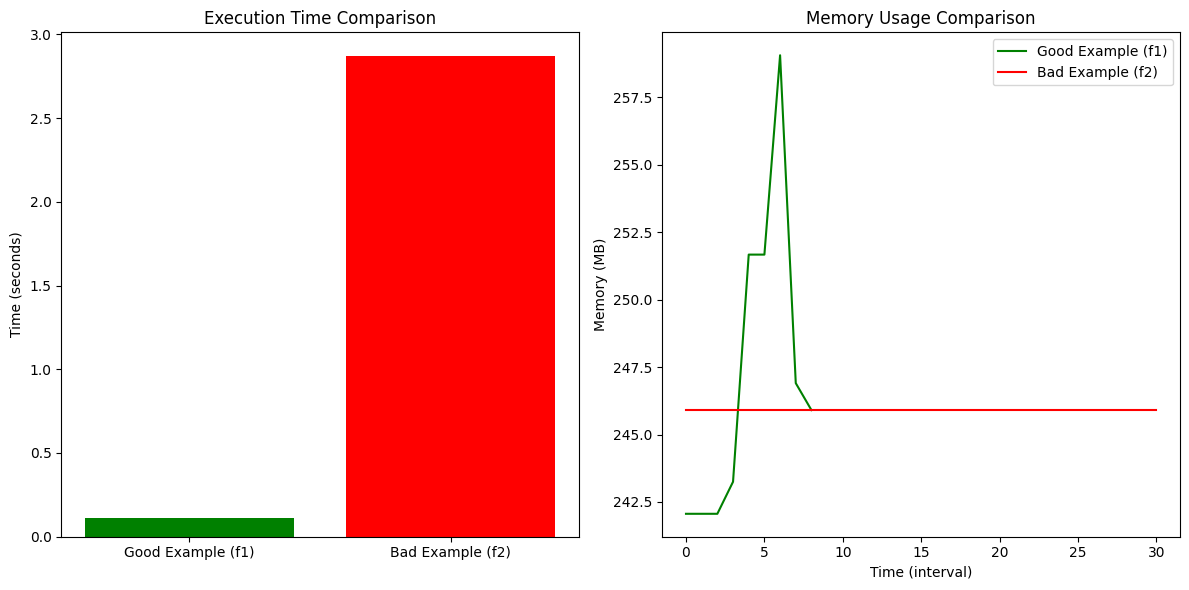

In [17]:
time_f1 = measure_time(lambda: convert_to_lower_good(df))  # Use a lambda function to delay the execution
time_f2 = measure_time(convert_to_lower_wrong)

mem_f1 = measure_memory(lambda: convert_to_lower_good(df))
mem_f2 = measure_memory(convert_to_lower_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)

# Using loc for complex conditions

## Don't do this

In [18]:
def modify_income_labels_wrong():
    for i in range(len(df)):
        if df.loc[i, "income"] == "<=50k":
            df.loc[i, "income"] = "low"
        elif df.loc[i, "income"] == ">50k":
            df.loc[i, "income"] = "high"

## Do this instead

In [19]:
def modify_income_labels_good():
    # Convert '<=50K' to 'low' and '>50K' to 'high'
    df.loc[df["income"] == "<=50k", "income"] = "low"
    df.loc[df["income"] == ">50k", "income"] = "high"

## Time - memory comparison

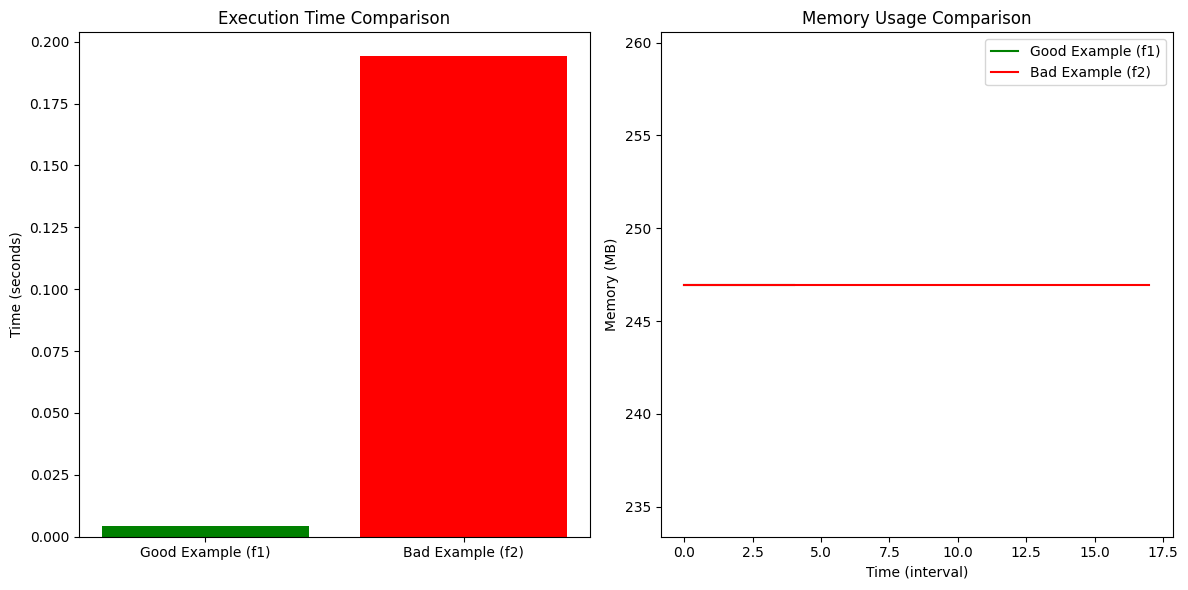

In [20]:
time_f1 = measure_time(modify_income_labels_good)
time_f2 = measure_time(modify_income_labels_wrong)

mem_f1 = measure_memory(modify_income_labels_good)
mem_f2 = measure_memory(modify_income_labels_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)

# Group by apply

## Don't do this

In [21]:
def generate_education_summary_wrong():
    # Get unique education levels
    unique_education_levels = df["education"].unique()

    # Initialize an empty list to store results
    summary = []

    # Loop through each education level
    for education in unique_education_levels:
        # Filter the data for the current education level
        group = df[df["education"] == education]

        # Calculate statistics
        average_age = group["age"].mean()
        average_hours = group["hours_per_week"].mean()
        total_people = len(group)

        # Append the results as a dictionary
        summary.append({
            "education": education,
            "average_age": average_age,
            "average_hours_per_week": average_hours,
            "total_people": total_people
        })

    # Convert the summary list to a DataFrame
    education_summary = pd.DataFrame(summary)

## Do this instead

In [22]:
def generate_education_summary_good():
    def summarize(group):
        return pd.Series({
            "average_age": group["age"].mean(),
            "average_hours_per_week": group["hours_per_week"].mean(),
            "total_people": len(group)
        })

    education_summary = df.groupby("education").apply(summarize).reset_index()

## Time - memory comparison

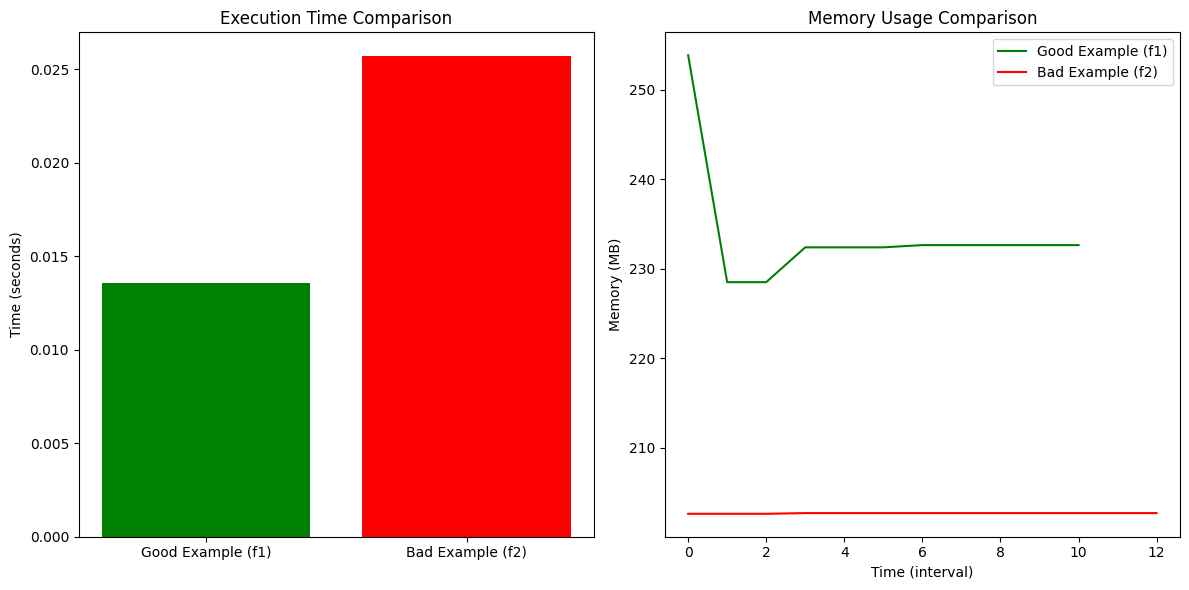

In [23]:
time_f1 = measure_time(generate_education_summary_good)
time_f2 = measure_time(generate_education_summary_wrong)

mem_f1 = measure_memory(generate_education_summary_good)
mem_f2 = measure_memory(generate_education_summary_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)

#  Verifying Equality Between DataFrames

## Don't do this

In [24]:
def test_df_equality_wrong():
    df_copy = df.copy()
    are_equal = True
    for i in range(len(df)):
        if not (df.iloc[i] == df_copy.iloc[i]).all():
            are_equal = False
            break

    if are_equal:
        print("The DataFrames are equal (manual check).")
    else:
        print("The DataFrames are NOT equal (manual check).")

## Do this instead

In [25]:
def test_df_equality_good():
    # Create an identical DataFrame for testing
    df_copy = df.copy()

    # Assert the two DataFrames are equal
    try:
        assert_frame_equal(df, df_copy)
        print("The DataFrames are equal.")
    except AssertionError:
        print("The DataFrames are NOT equal.")

## Time - memory comparison

The DataFrames are equal.
The DataFrames are equal (manual check).
The DataFrames are equal.
The DataFrames are equal (manual check).


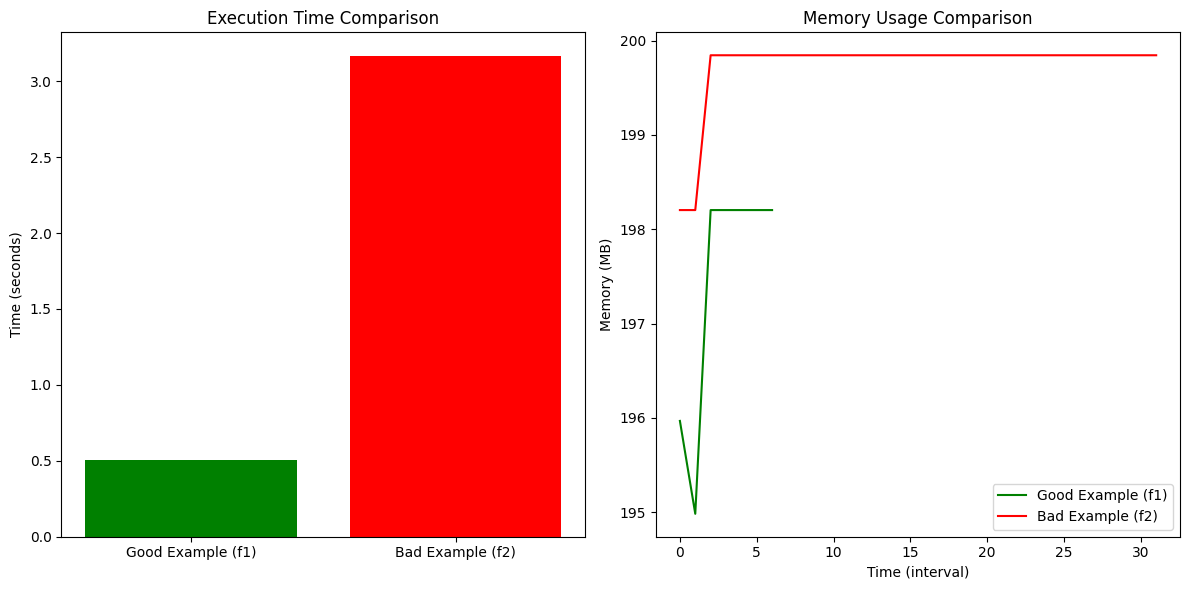

In [26]:
time_f1 = measure_time(test_df_equality_good)
time_f2 = measure_time(test_df_equality_wrong)

mem_f1 = measure_memory(test_df_equality_good)
mem_f2 = measure_memory(test_df_equality_wrong)

plot_performance_comparison(time_f1, time_f2, mem_f1, mem_f2)